**1. Environment**

In [6]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
from scipy.stats import genextreme as gev

# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

! pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:55:52) 
[GCC 7.5.0]
Virtual memory usage - total: 94 GB / available: 85 GB / percent used: 9.4 %
/home/philinat/Stage-M2


**2. Geographical coordinates**

In [7]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/MARgrid_EUy.nc')
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi',
                 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

(<matplotlib.lines.Line2D at 0x7fd619e0cd00>,)

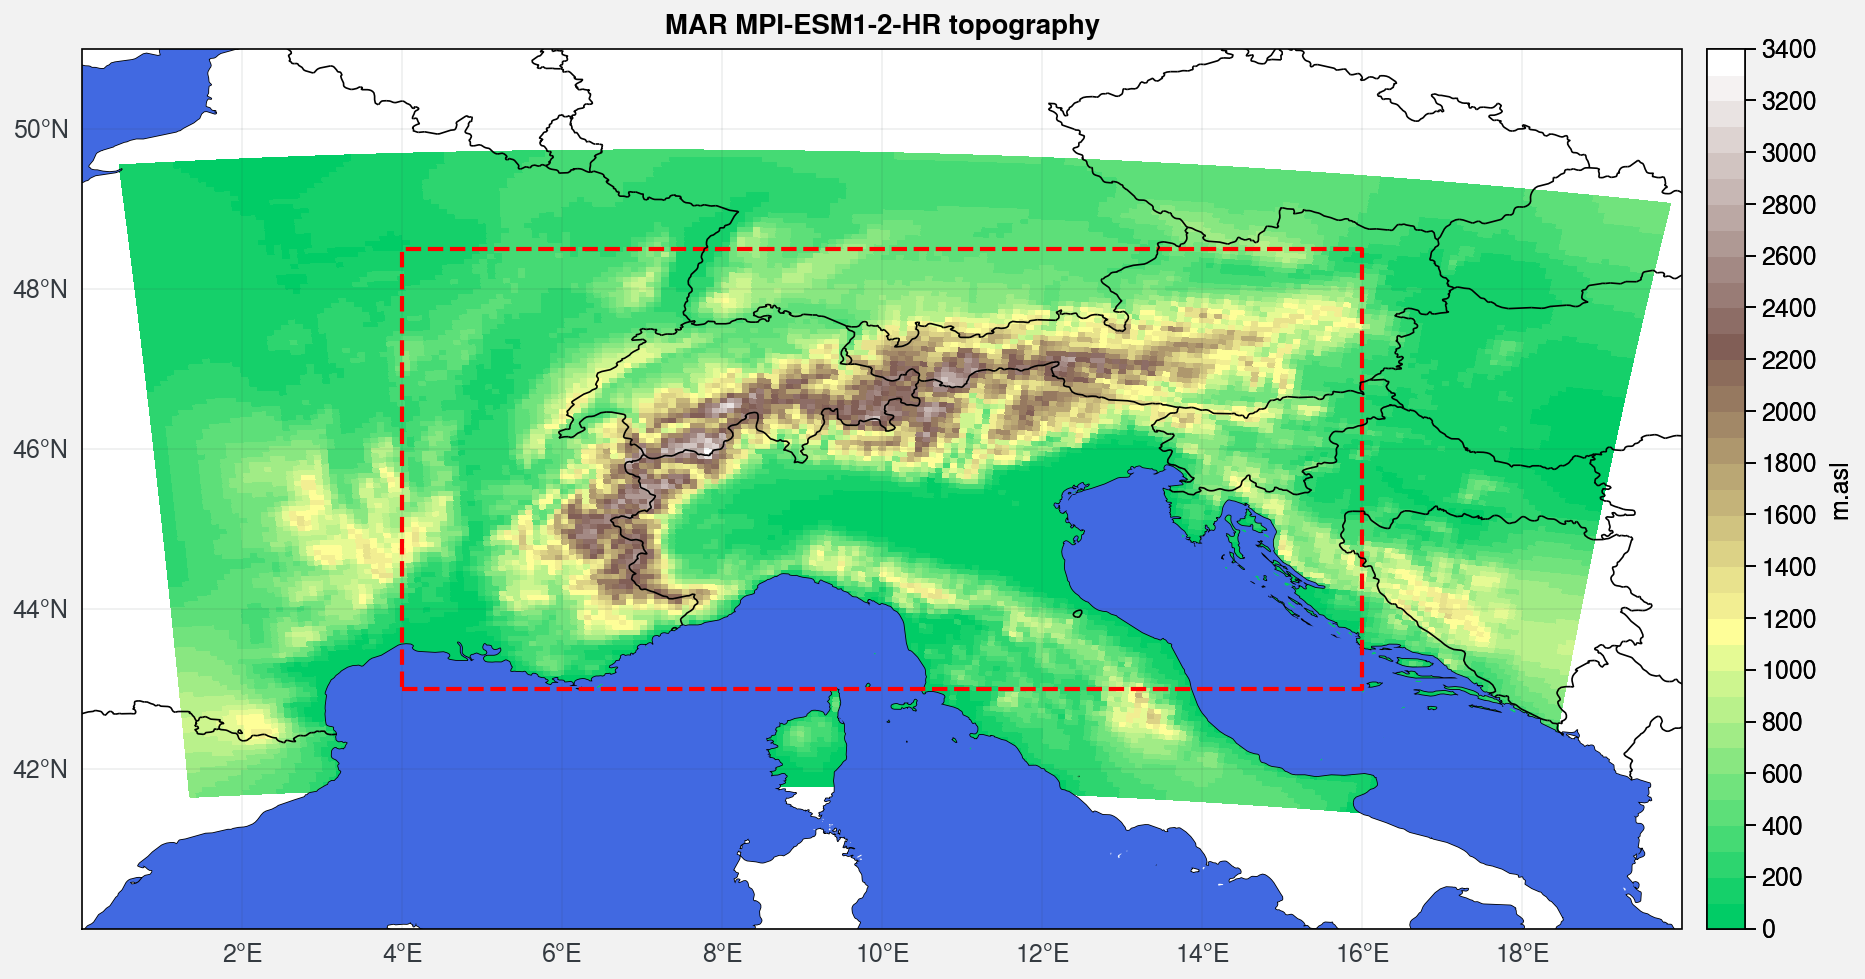

In [3]:
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=34,cmap=colors_land)
f.colorbar(m,label= 'm.asl')

ax.format(**normal_format,suptitle='MAR MPI-ESM1-2-HR topography')
ax.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

**3 Seasonal means**

In [10]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [11]:
first_year = 1961
last_year = 2100
les_season_mean = np.zeros(((last_year-first_year+1),4,126,201))
les_season_max = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.MBrr.'+str(year)+'.nc')
        ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.MBsf.'+str(year)+'.nc')
    else:
        ds_rr = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.MBrr.'+str(year)+'.nc')
        ds_sf = xr.open_dataset('/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.MBsf.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_rr.MBrr+ds_sf.MBsf).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_mean[year-first_year] = season_mean_year
    season_max_year=(ds_rr.MBrr+ds_sf.MBsf).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    les_season_max[year-first_year] = season_max_year



1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [12]:
np.save('/home/philinat/Stage-M2/saved_data_MAR_MPI_daily_mean_max/les_season_mean.npy', les_season_mean)
np.save('/home/philinat/Stage-M2/saved_data_MAR_MPI_daily_mean_max/les_season_max.npy', les_season_max)

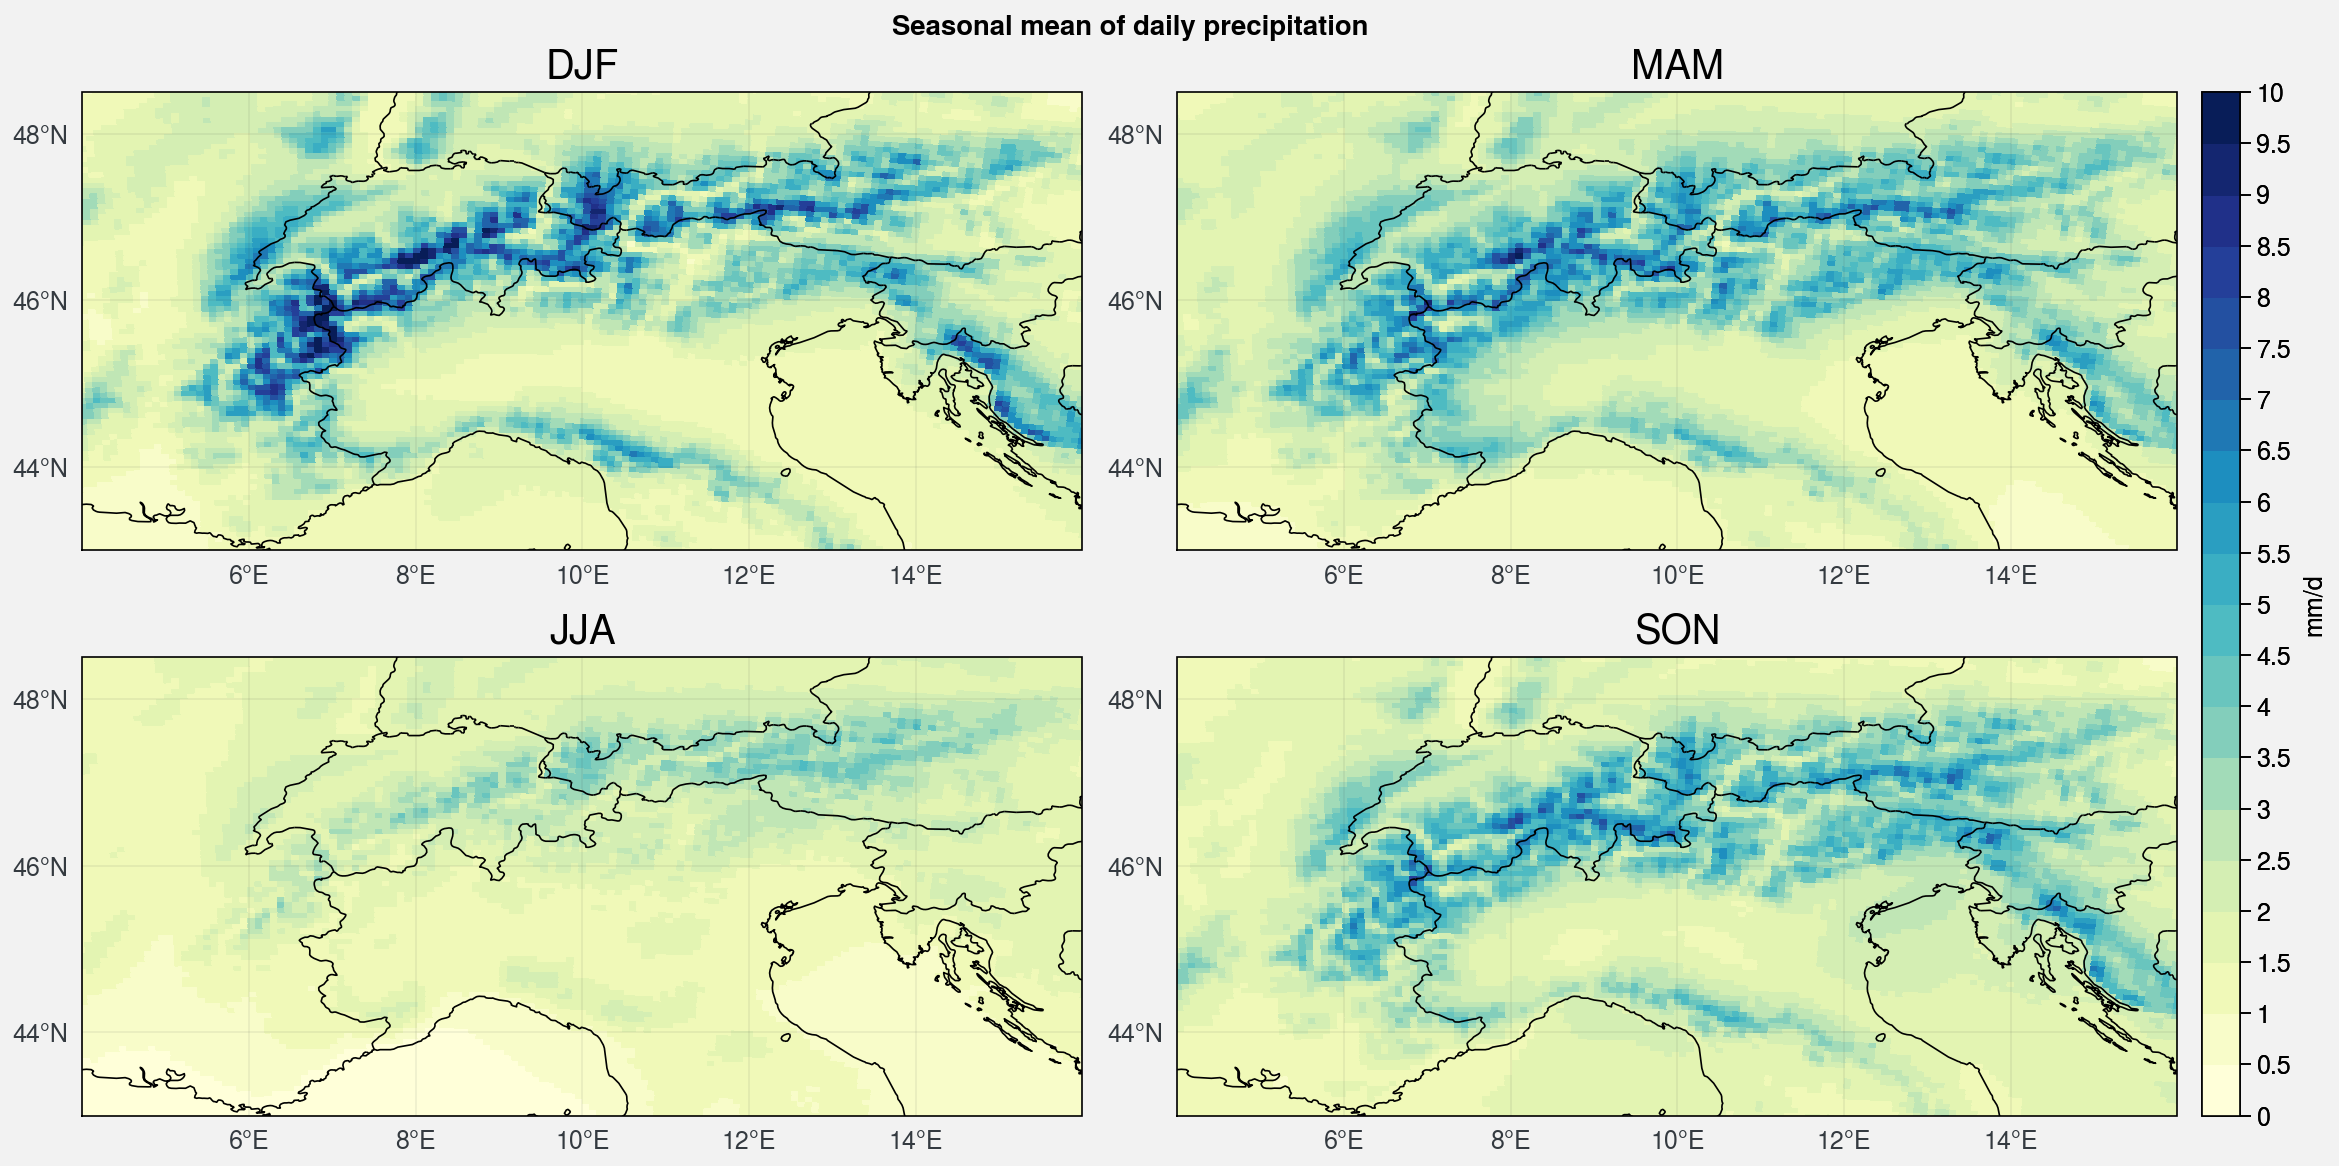

In [13]:
les_season_mean = np.load('/home/philinat/Stage-M2/saved_data_MAR_MPI_daily_mean_max/les_season_mean.npy')
seasonal_mean = np.mean(les_season_mean,axis=0)
f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(0,10,21),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Seasonal mean of daily precipitation")


**4 Extremes**

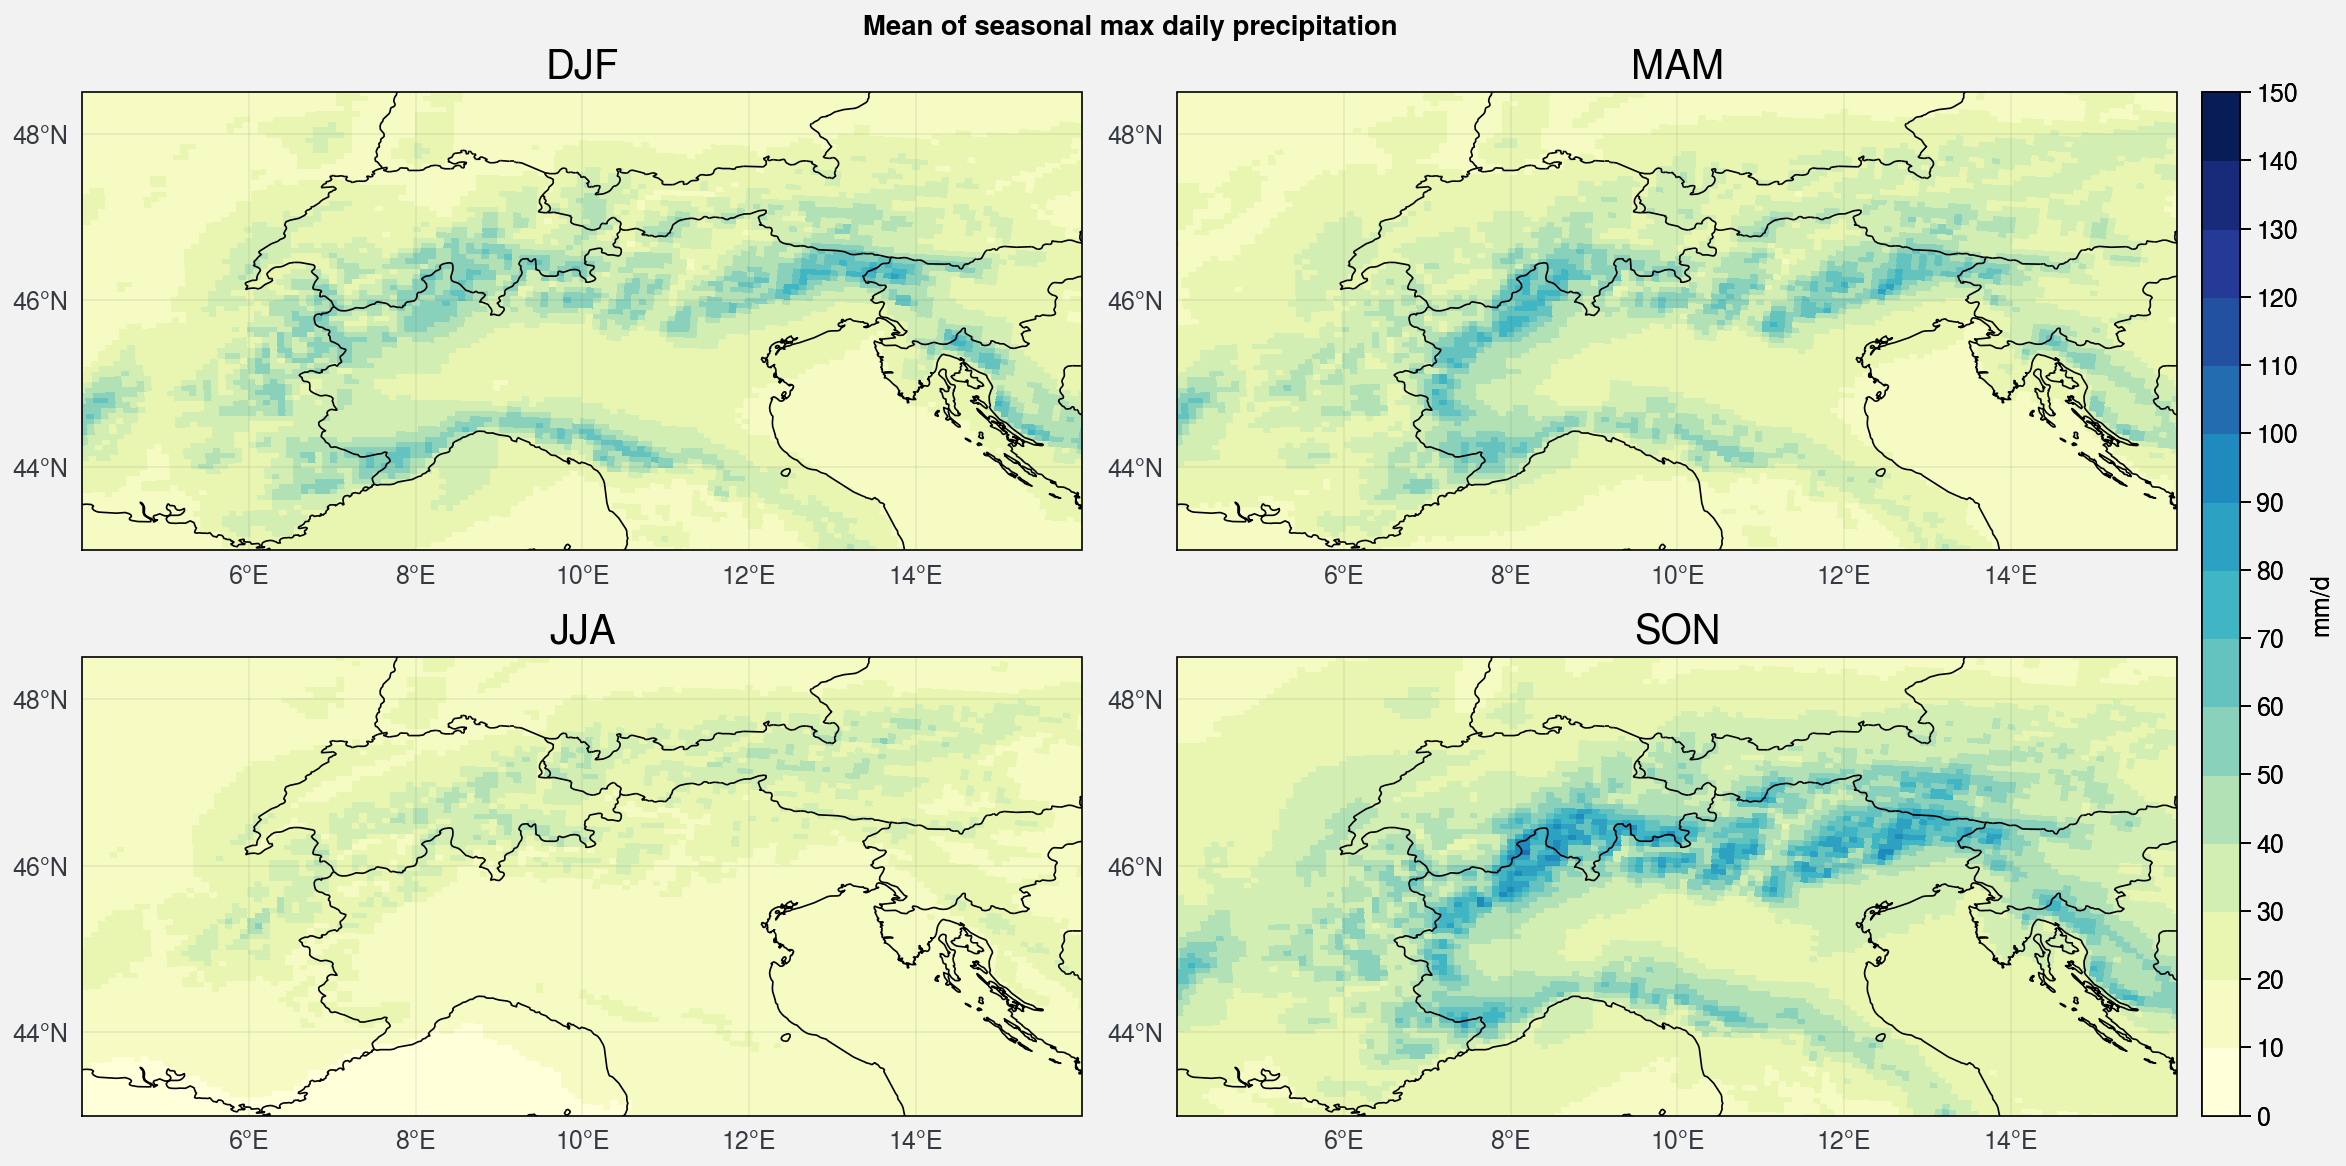

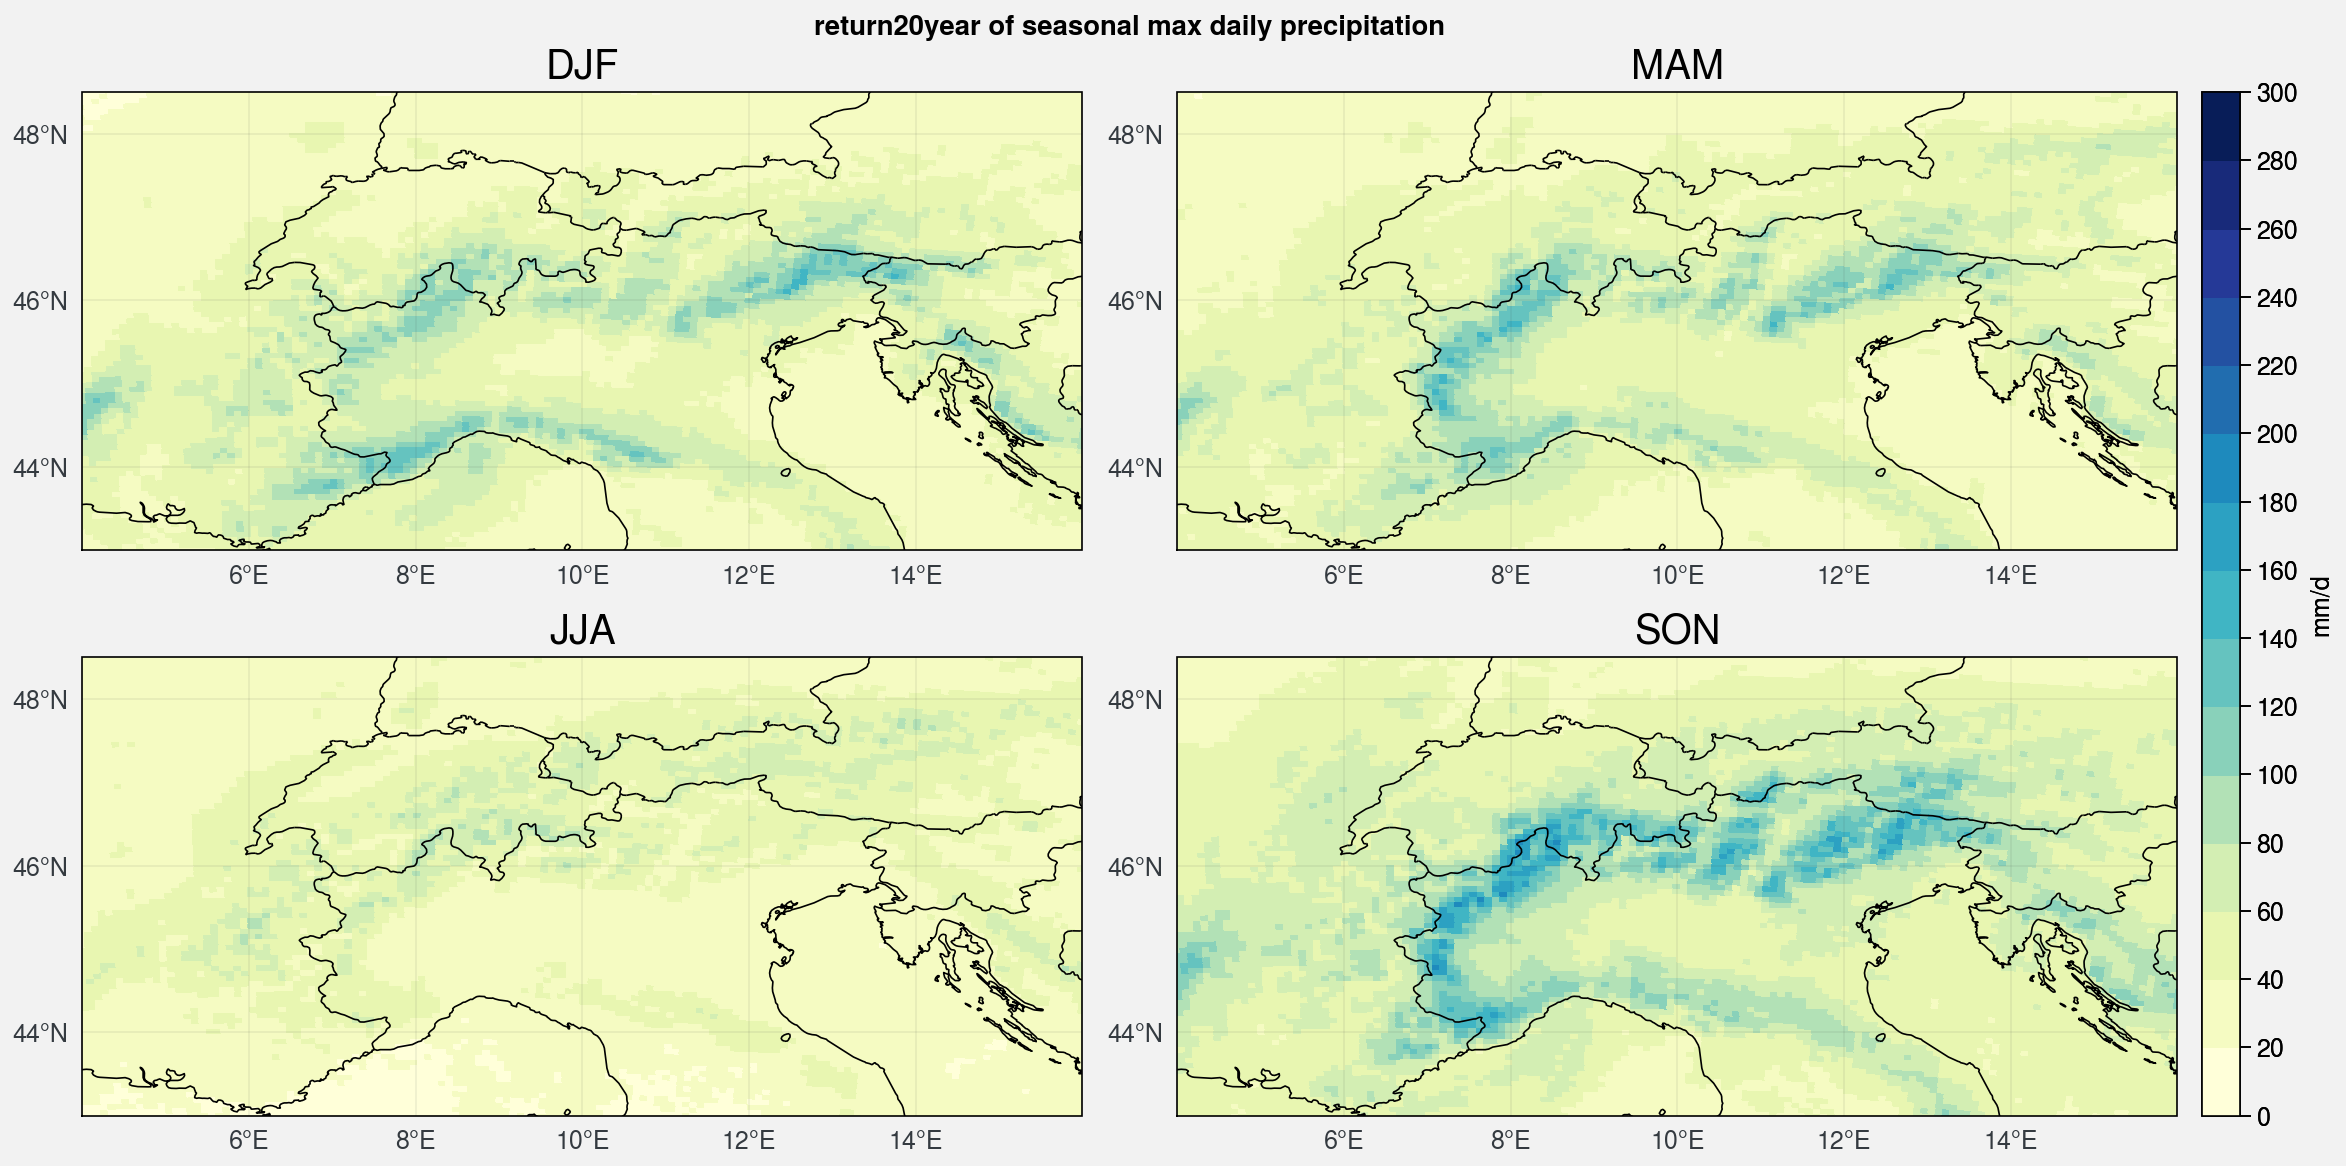

In [15]:
les_season_max = np.load('/home/philinat/Stage-M2/saved_data_MAR_MPI_daily_mean_max/les_season_max.npy')

f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.mean(les_season_max[:,i,:,:],axis=0),levels=np.linspace(0,150,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="Mean of seasonal max daily precipitation")

f, axs = pplt.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,np.quantile(les_season_max[:,i,:,:],0.95,axis=0),levels=np.linspace(0,300,16),cmap='YlGnBu')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= 'mm/d')

axs.format(**normal_format,suptitle="return20year of seasonal max daily precipitation")